In [1]:
%load_ext autoreload
%autoreload 2
from definitions import *
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from itertools import product
from matplotlib.gridspec import GridSpec

# S300, SOM

In [32]:
exp_som = ClusteringExperiment('ERA5', 'Wind', '300', None, None, -80, 40, 20, 80, False, 'anomaly', 'JJA')


In [34]:
net, centers = exp_som.compute_som(10, 10, 180, True, False, True, inner_dist_type='grid', train_kwargs=dict(train_algo='online'))

2023-04-18 16:39:34.476 | INFO     | simpsom.network:__init__:144 - Periodic Boundary Conditions active.
2023-04-18 16:39:34.477 | INFO     | simpsom.network:__init__:154 - Hexagonal topology.
2023-04-18 16:39:34.478 | WARNING  | simpsom.network:_set_weights:224 - Please be sure that the data have been standardized before using PCA.
2023-04-18 16:39:34.479 | INFO     | simpsom.network:_set_weights:227 - The weights will be initialized with PCA.
2023-04-18 16:39:34.496 | INFO     | simpsom.network:train:395 - The map will be trained with the online algorithm.
2023-04-18 16:39:39.373 | INFO     | simpsom.network:save_map:312 - Map shape and weights will be saved to:
/storage/scratch/users/hb22g102/ERA5/Wind/300/box_-80_40_20_80/som_10_10_anomaly_JJA_sqrtcos_OPP.npy


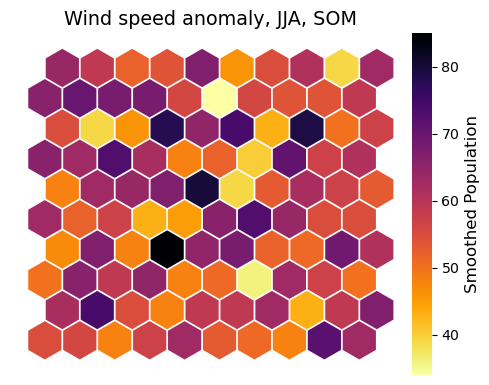

In [35]:
kwargs = {
    "cmap": mpl.colormaps["inferno"].reversed(),
    "cbar_label": "Smoothed Population",
    "title": "Wind speed anomaly, JJA, SOM",
}

populations = net.compute_populations()
fig, ax = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=True,
    **kwargs
)


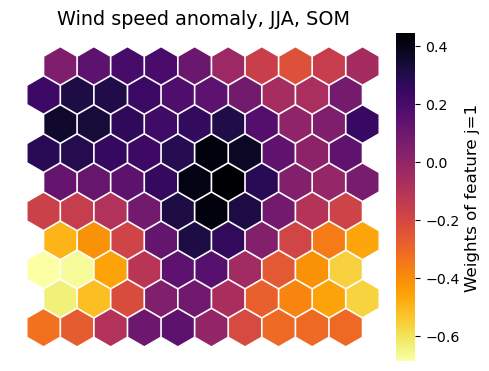

In [48]:
j = 1
kwargs = {
    "cmap": mpl.colormaps["inferno"].reversed(),
    "cbar_label": f"Weights of feature {j=}",
    "title": "Wind speed anomaly, JJA, SOM",
}

fig, ax = net.plot_on_map(
    net.weights[:, j],
    **kwargs
)

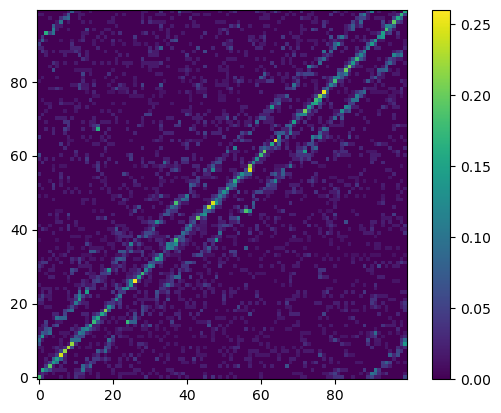

In [37]:
trans_mat = net.compute_transmat()
fig, ax = plt.subplots()
im = ax.imshow(trans_mat, origin="lower")
fig.colorbar(im, ax=ax)


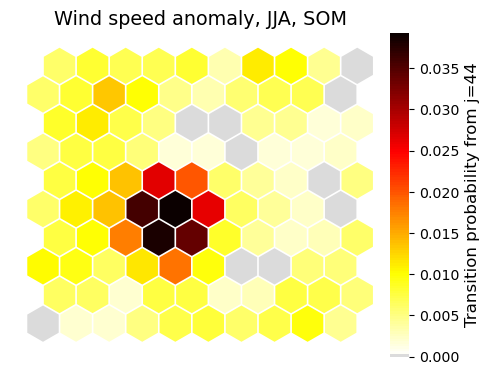

In [38]:
cmap = mpl.colormaps["hot"].reversed()(np.linspace(0, 1, 128))
cmap[:1, :3] = (np.asarray([220, 220, 220]) / 256)[None, :]
cmap = ListedColormap(cmap)
j = np.random.randint(0, net.width * net.height)
kwargs = {
    "cmap": cmap,
    "cbar_label": f"Transition probability from {j=}",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}
probas = trans_mat[:, j]
fig, ax = net.plot_on_map(
    probas,
    smooth_sigma=1,
    show=True,
    **kwargs
)


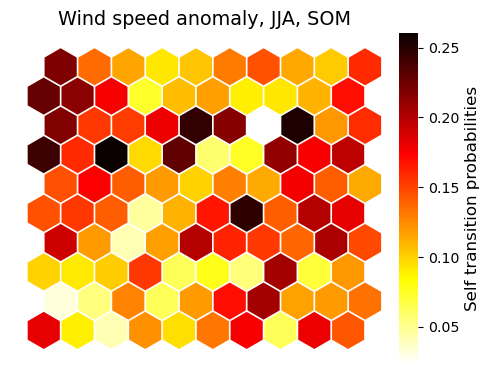

In [39]:
cmap = mpl.colormaps["hot"].reversed()
kwargs = {
    "cmap": cmap,
    "cbar_label": f"Self transition probabilities",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    np.diag(trans_mat),
    smooth_sigma=0,
    show=True,
    **kwargs
)

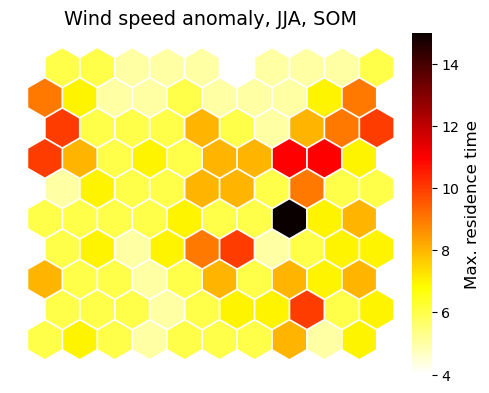

In [40]:
rt_max = net.compute_residence_time('max', smooth_sigma=1)

kwargs = {
    "cmap": cmap,
    "cbar_label": f"Max. residence time",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    rt_max,
    smooth_sigma=0,
    **kwargs
)

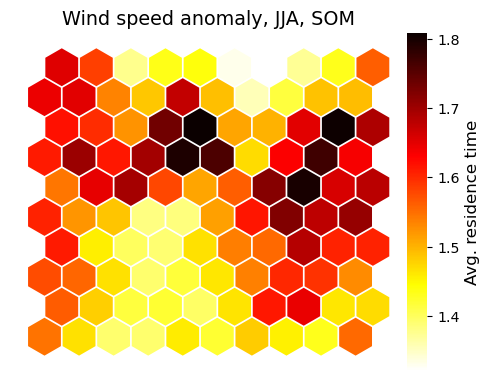

In [41]:
rt_max = net.compute_residence_time('mean', smooth_sigma=1)

kwargs = {
    "cmap": cmap,
    "cbar_label": f"Avg. residence time",
    "title": "Wind speed anomaly, JJA, SOM",
    "levels": np.arange(15),
}

fig, ax = net.plot_on_map(
    rt_max,
    smooth_sigma=0,
    **kwargs
)

In [42]:
projected = net.project_onto_map(net.data)
da_som = exp_som.open_da('anomaly', 'JJA')
indices = net.bmus

2023-04-18 16:40:00.619 | INFO     | simpsom.network:project_onto_map:596 - Projected coordinates will be saved to:
/storage/scratch/users/hb22g102/ERA5/Wind/300/box_-80_40_20_80/./som_projected.npy


In [43]:
exp_T = Experiment(exp_som.dataset, 'Temperature', '2m', exp_som.region, 't')
da_T = exp_T.open_da('anomaly', 'JJA')
da_T = da_T.drop_duplicates(dim='time').interp(time=da_som.time)

In [44]:
multimask = (indices[:, None] == np.arange(net.height * net.width)[None, :]).reshape(-1, net.width, net.height)

In [45]:
center_temps = xr.DataArray(np.empty((net.width, net.height, *da_T.shape[1:])), coords=centers.coords)
for i, j in product(range(net.width), range(net.height)):
    center_temps[i, j] = da_T.isel(time=multimask[:, i, j]).mean(dim='time')

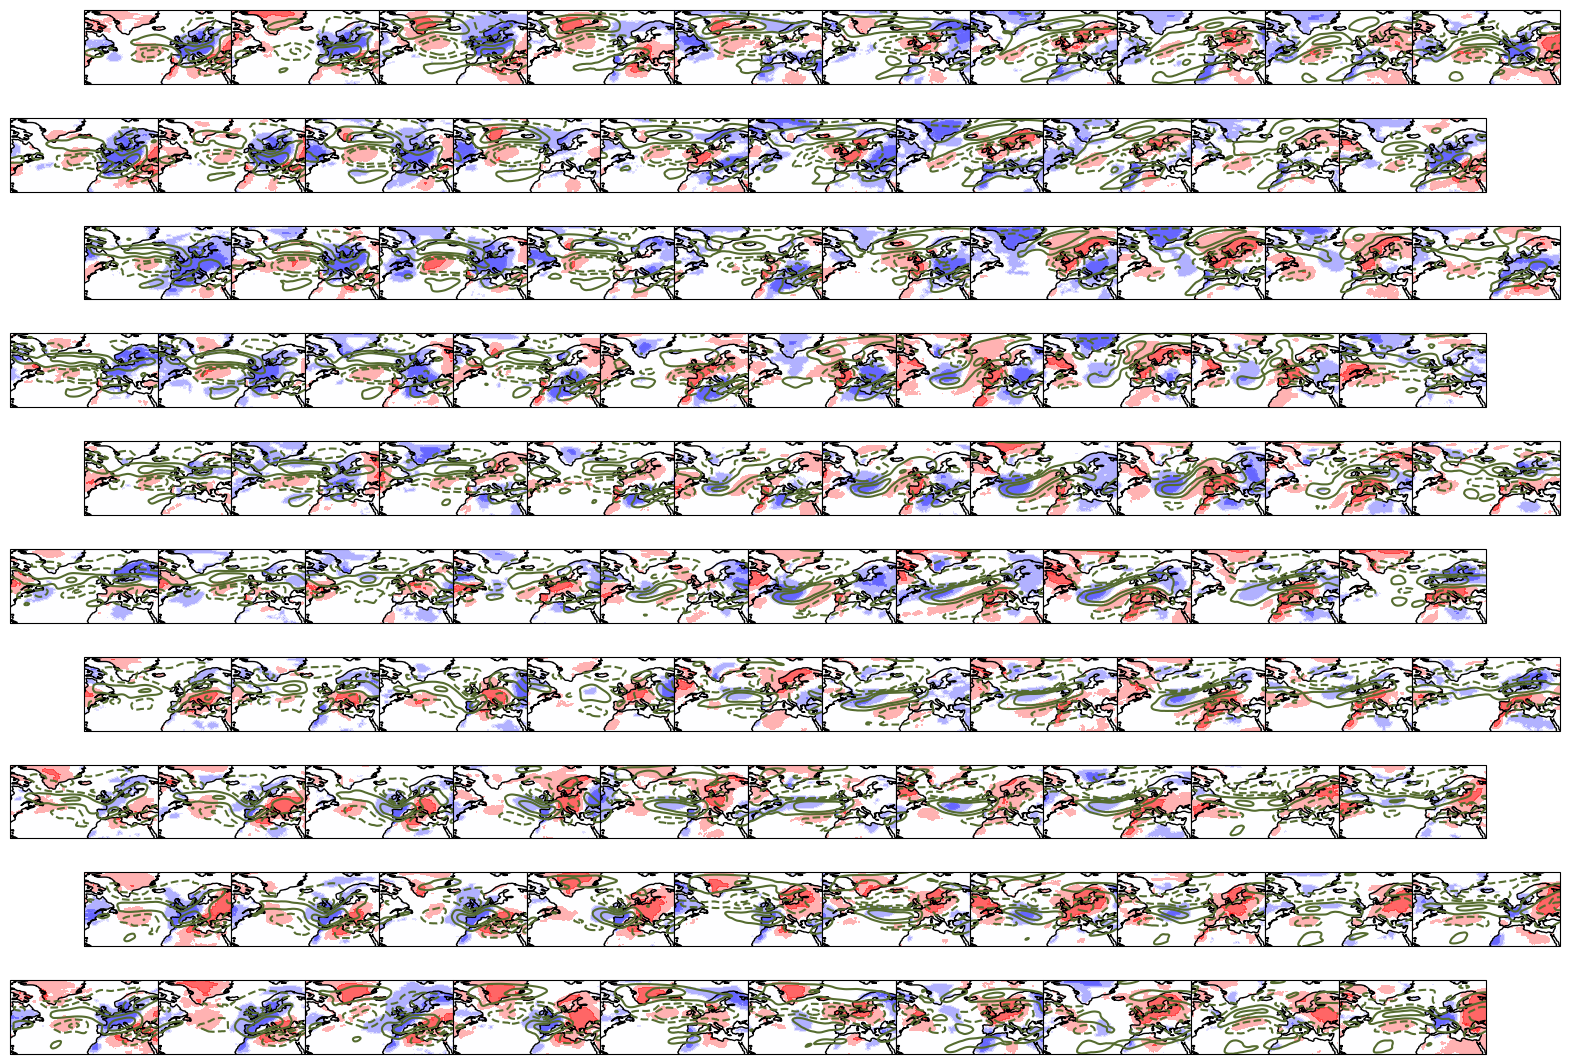

In [47]:
nx, ny = net.width, net.height
fig = plt.figure(figsize=(20, 14))
gs = GridSpec(nx, 2 * ny + 1, hspace=0, wspace=0)
tbd = []
axes = []
lon = centers["lon"].values
lat = centers["lat"].values
cmap_temp = mpl.colormaps['bwr']
cmap_wind = mpl.colormaps['BrBG']
qlist = [0.025, 0.15, 0.85, .975]
levels_temp = center_temps.quantile(qlist).values
norm_temp = BoundaryNorm(levels_temp, cmap_temp.N, extend='both')
levels_wind = centers.quantile(qlist).values

for n, (j, i) in enumerate(product(range(ny), range(nx))):
    if i % 2 == 0:
        slice_y = slice(2 * j, 2 * j + 2)
    else:
        slice_y = slice(2 * j + 1, 2 * j + 2 + 1)
    axes.append(fig.add_subplot(gs[nx - i - 1, slice_y], projection=ccrs.PlateCarree()))
    axes[-1].set_xticks([])
    axes[-1].set_yticks([])
    axes[-1].contourf(
        lon, lat, center_temps.isel(x=i, y=j), cmap=cmap_temp, levels=levels_temp, norm=norm_temp, extend='both', alpha=0.6
    )
    axes[-1].contour(
        lon, lat, centers.isel(x=i, y=j), levels=levels_wind, colors='darkolivegreen'
    )
    axes[-1].add_feature(COASTLINE)
if i % 2 == 0:
    tbd.append(fig.add_subplot(gs[i, -1]).set_visible(False))
else:
    tbd.append(fig.add_subplot(gs[i, 0]).set_visible(False))


## Intransivity

In [17]:
allnodes = np.arange(net.width * net.height)
indices_mask = indices[:, None] == np.arange(net.width * net.height)[None, :]
indices_mask = xr.DataArray(indices_mask, coords={'time': da_som.time.values, 'node': allnodes})

In [18]:
indices_mask.resample(time='1YS').any(dim='time')

<xarray.DataArray (time: 63, node: 16)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * node     (node) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * time     (time) datetime64[ns] 1959-01-01 1960-01-01 ... 2021-01-01

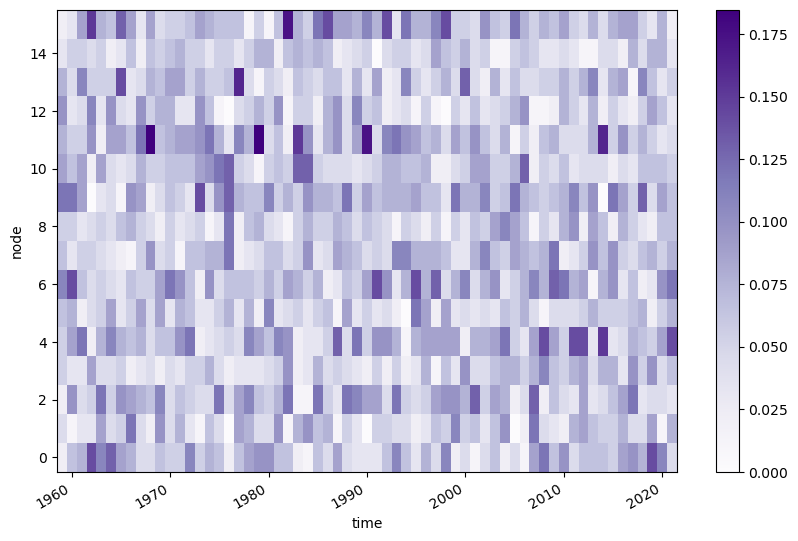

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = LinearSegmentedColormap.from_list(
    "gr",
    [
        [21 / 256, 176 / 256, 26 / 256, 1],
        [1, 1, 1, 1],
        [229 / 256, 0, 0, 1],
    ],
    N=50,
)
to_plot = indices_mask.resample(time='1YS').mean(dim='time').T
to_plot.plot.pcolormesh(cmap='Purples') #, linewidth=.5, edgecolors='white')

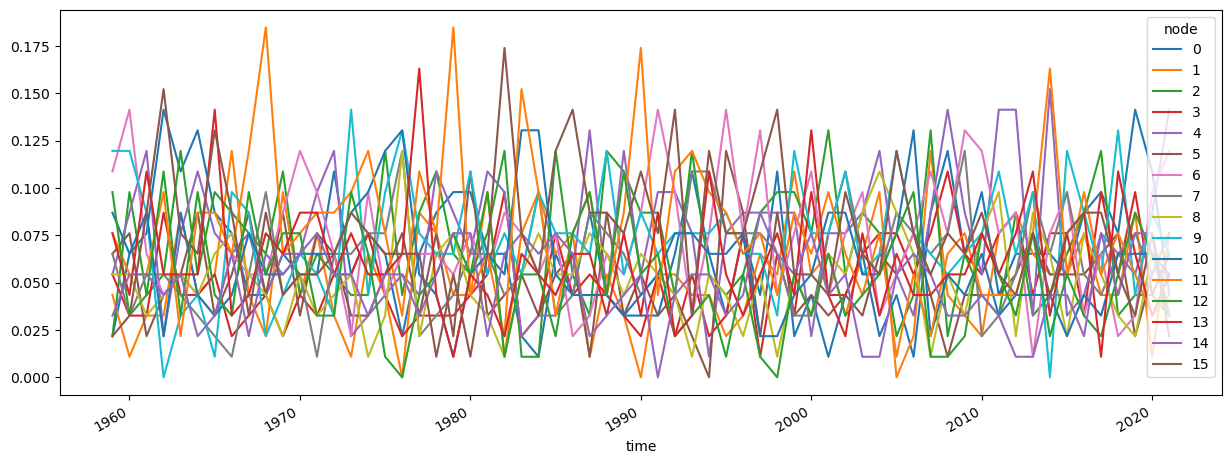

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
to_plot.plot.line(hue='node')

# OPPS

In [17]:
eigenvals, OPPs, path = exp_som.compute_opps(180, return_realspace=True)
raw_OPPs = load_pickle(path)['OPPs']

In [23]:
X, da = exp_som.prepare_for_clustering()
OPP_timeseries = exp_som.opp_transform(X, 180)
mask_high_val = OPP_timeseries > 2
mask_low_val = OPP_timeseries < -2

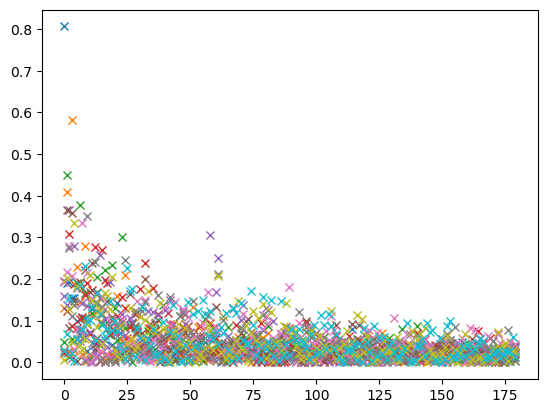

In [24]:
for i in range(10):
    plt.plot(np.abs(raw_OPPs[i, :]), 'x')

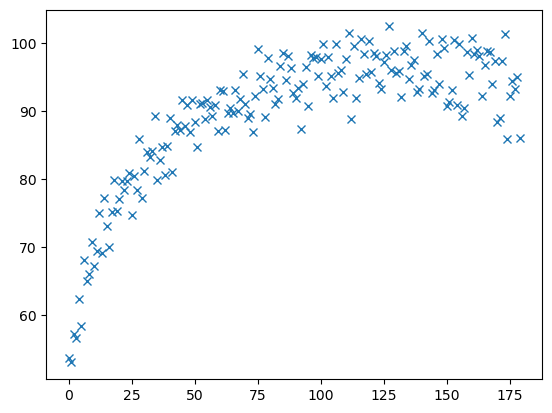

In [25]:
plt.plot(np.average(np.broadcast_to(np.arange(180)[None, :], raw_OPPs.shape), weights=np.abs(raw_OPPs), axis=1), 'x')

(<Figure size 1900x900 with 7 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
        <GeoAxes: >], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7f783fbff110>)

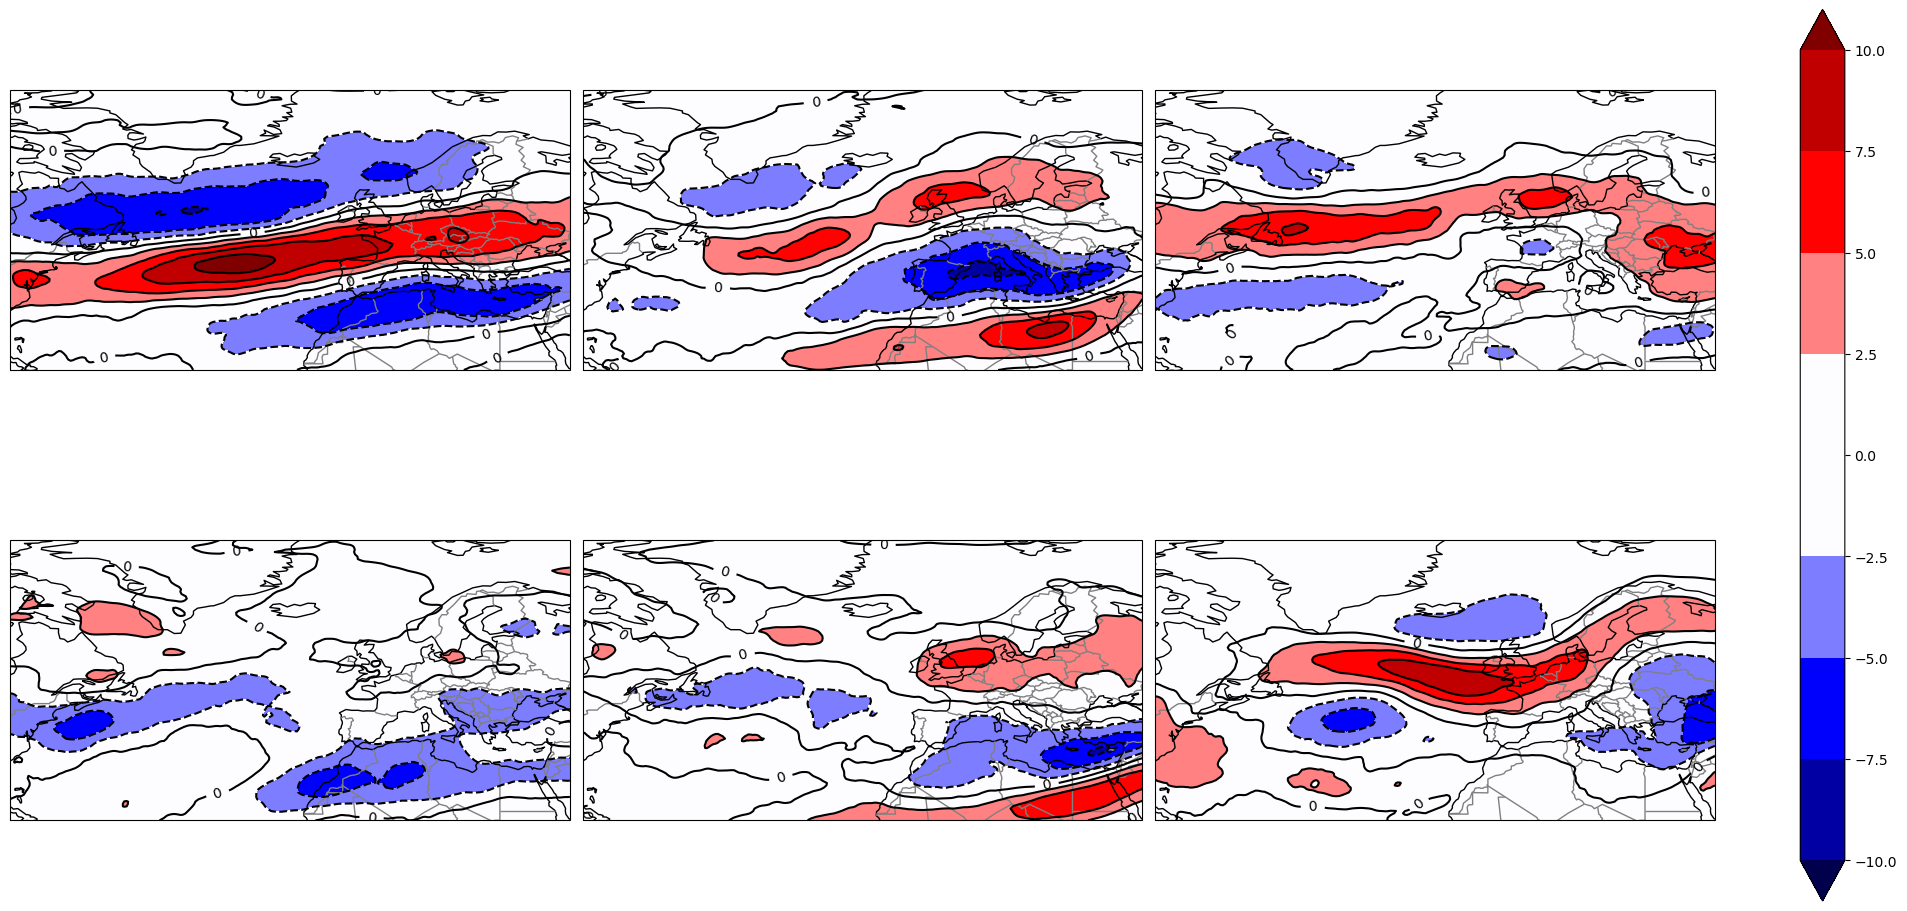

In [31]:
to_plot = [da.isel(time=mask_high_val[:, i]).mean(dim='time') for i in range(6)]
clusterplot(2, 3, to_plot, 5, 10, clabels=[0])

(<Figure size 1900x900 with 7 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
        <GeoAxes: >], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7f783f433350>)

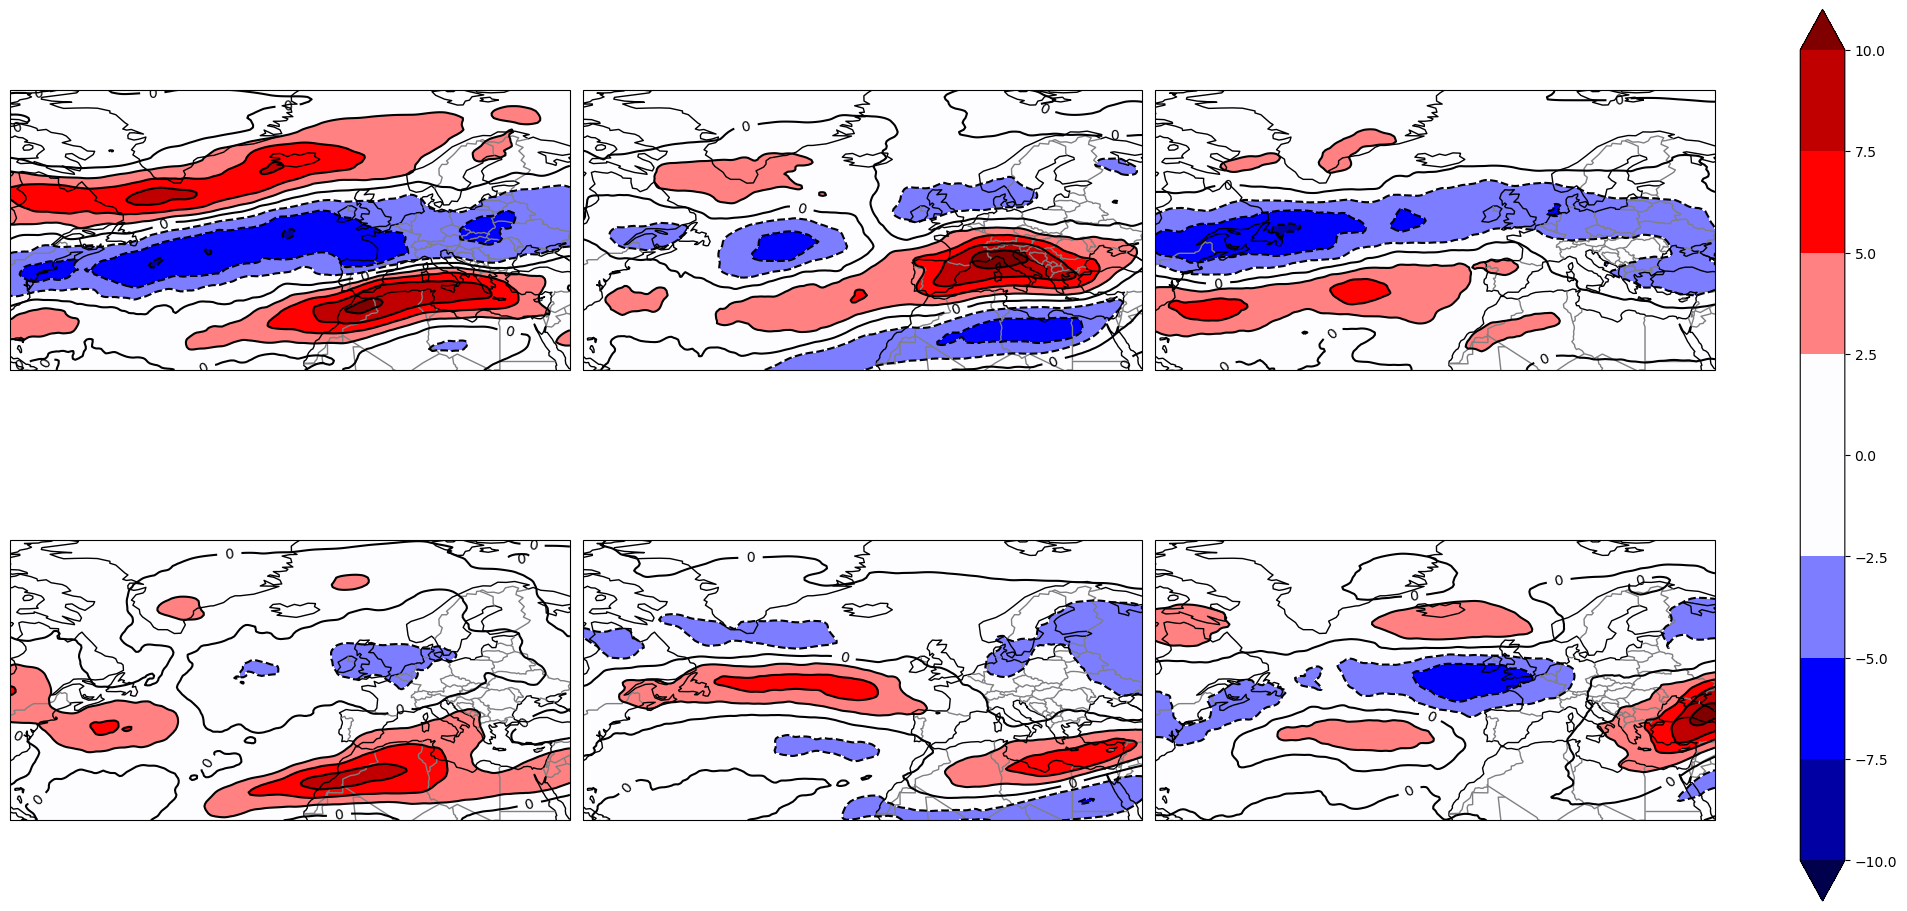

In [49]:
to_plot = [da.isel(time=mask_low_val[:, i]).mean(dim='time') for i in range(6)]
clusterplot(2, 3, to_plot, 5, 10, clabels=[0])

(<Figure size 1900x900 with 7 Axes>,
 array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >,
        <GeoAxes: >], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x7f78443f5a10>)

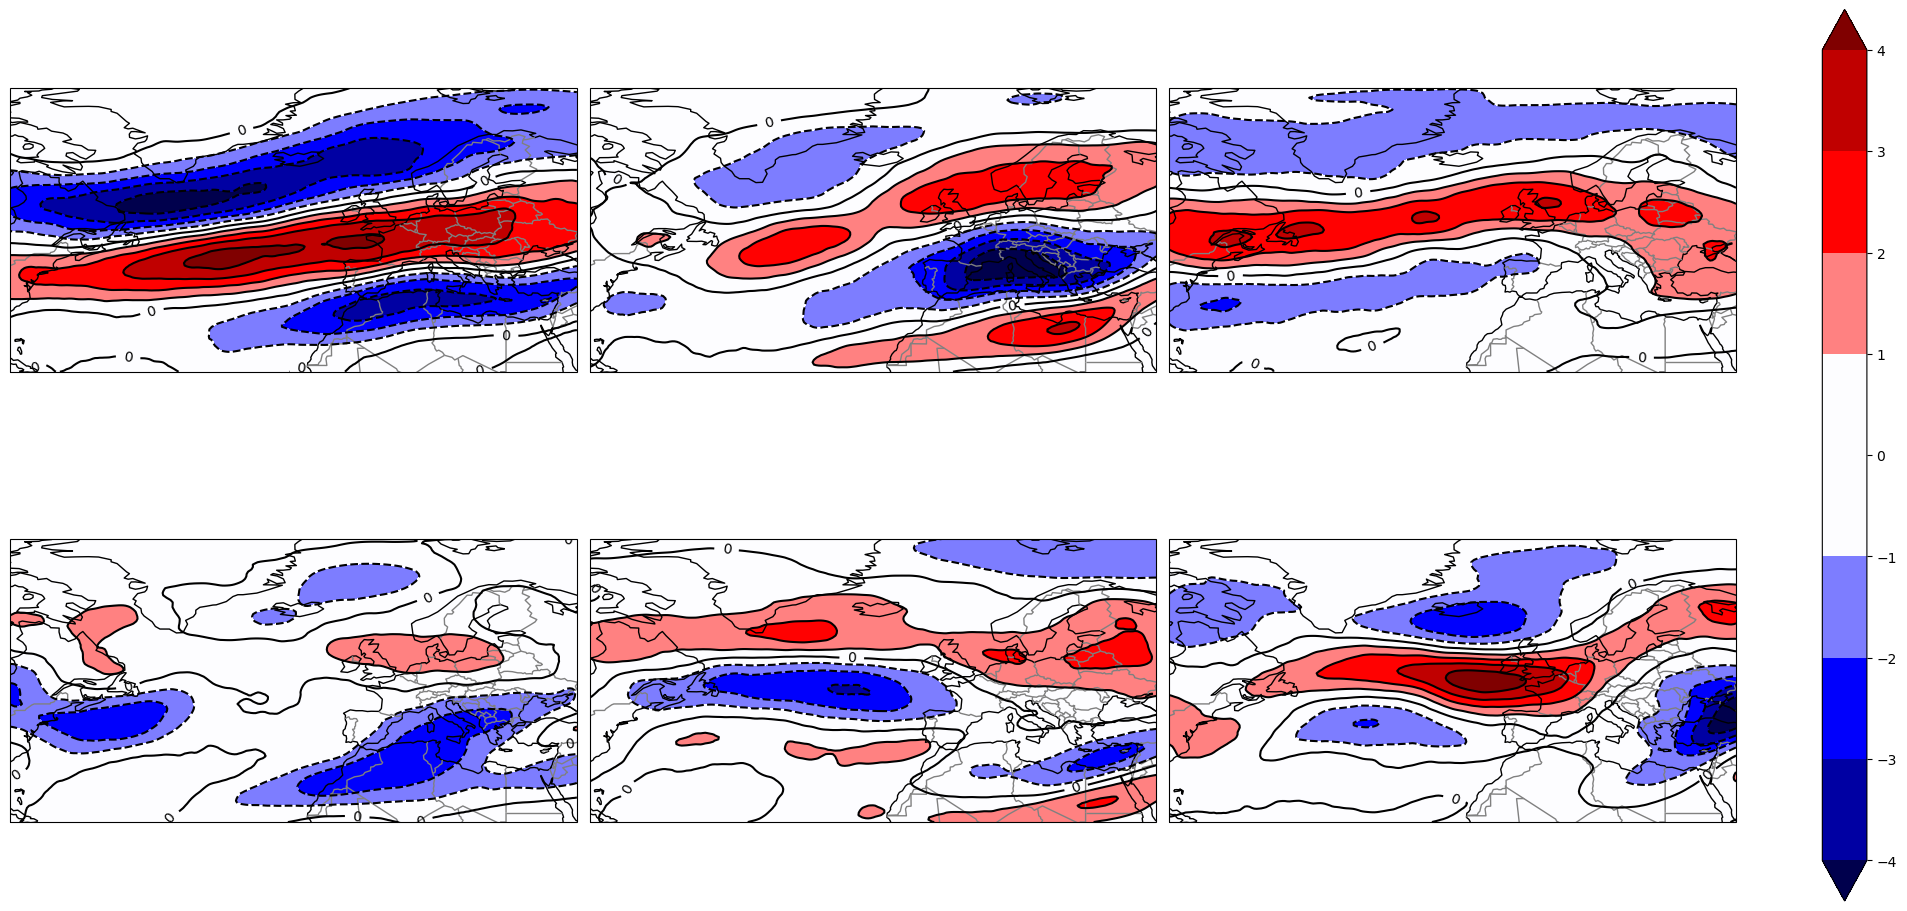

In [28]:
to_plot = OPPs[:6]
clusterplot(2, 3, to_plot, 5, 4, clabels=[0])

In [63]:
da.min()

<xarray.DataArray 's' ()>
array(-27.034712, dtype=float32)

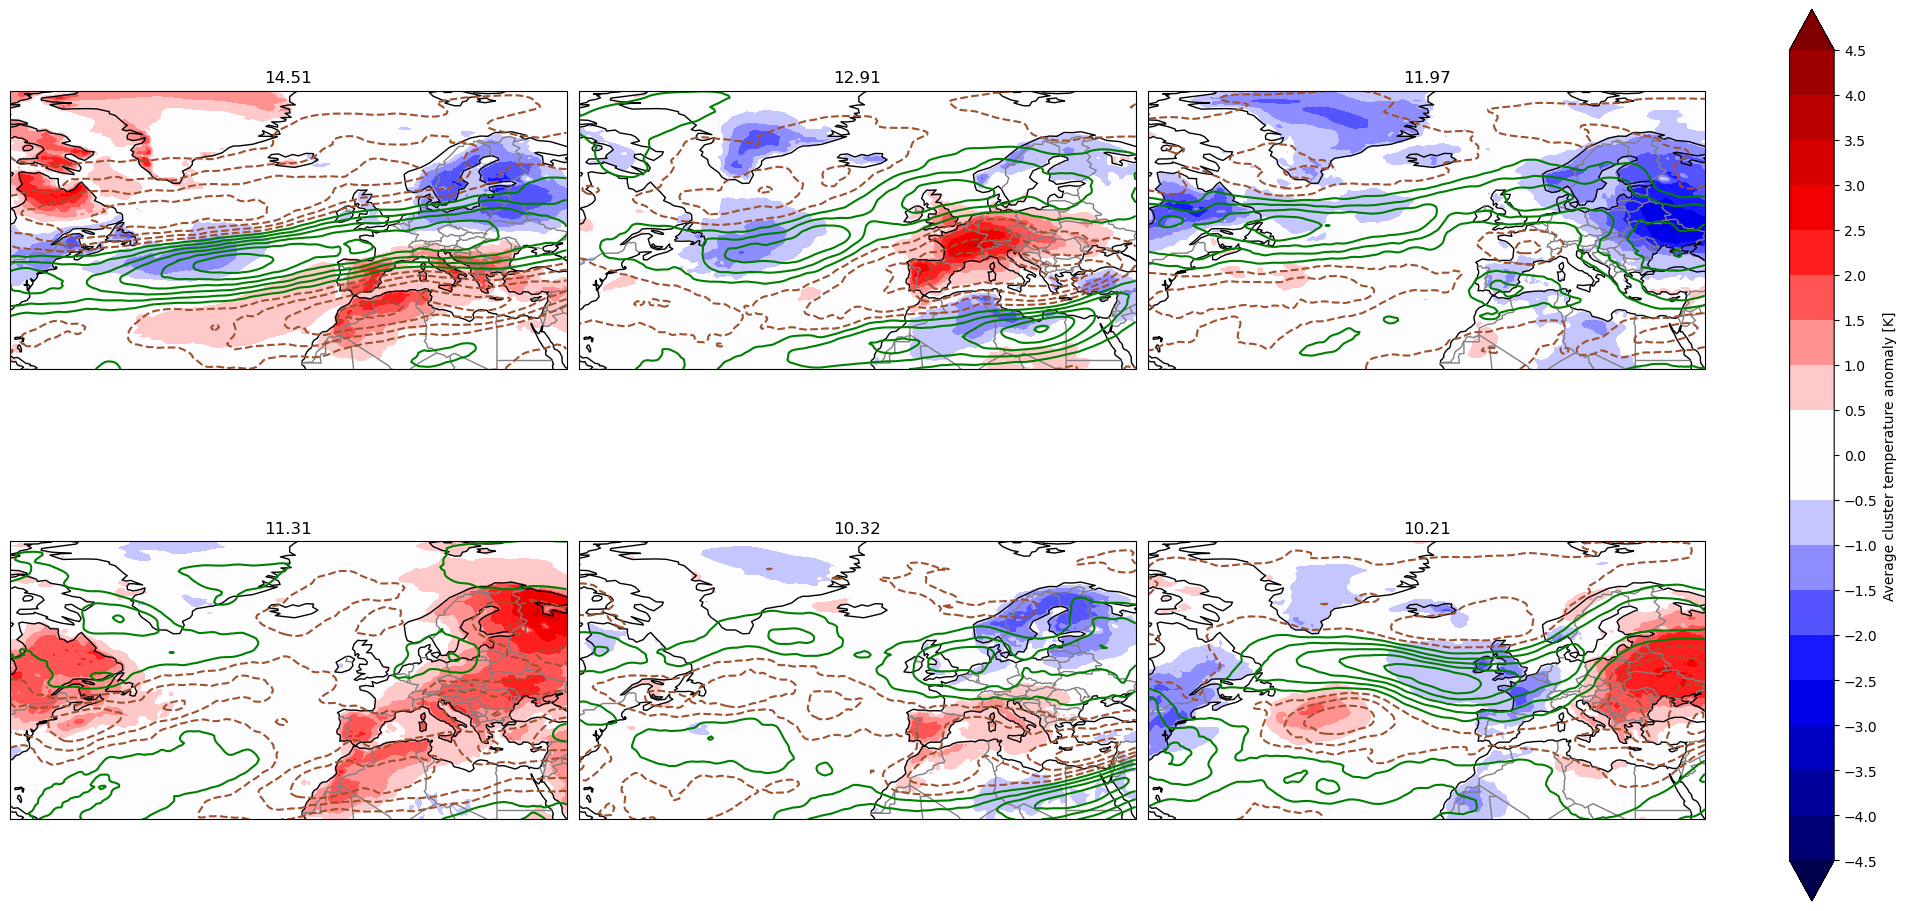

In [98]:
to_plot = [da_T.isel(time=mask_high_val[:, i]).mean(dim='time') for i in range(6)]
fig, axes, cbar = clusterplot(2, 3, to_plot, 10, 4.5, clabels=None, contours=False, cbar_ylabel='Average cluster temperature anomaly [K]')
to_plot = [da.isel(time=mask_high_val[:, i]).mean(dim='time') for i in range(6)]
levels = 12
levels2 = int(levels / 2)
colors = levels2 * ['sienna'] + (levels2 + 1) * ['green']
linestyles = levels2 * ['dashed'] + (levels2 + 1) * ['solid']
for ax, toplt, eigenval in zip(axes, to_plot, eigenvals):
    toplt.plot.contour(ax=ax, add_colorbar=False, add_labels=False, levels=levels, vmin=-10, vmax=10, colors=colors, linestyles=linestyles)
    ax.set_title(f'{eigenval:.2f}')

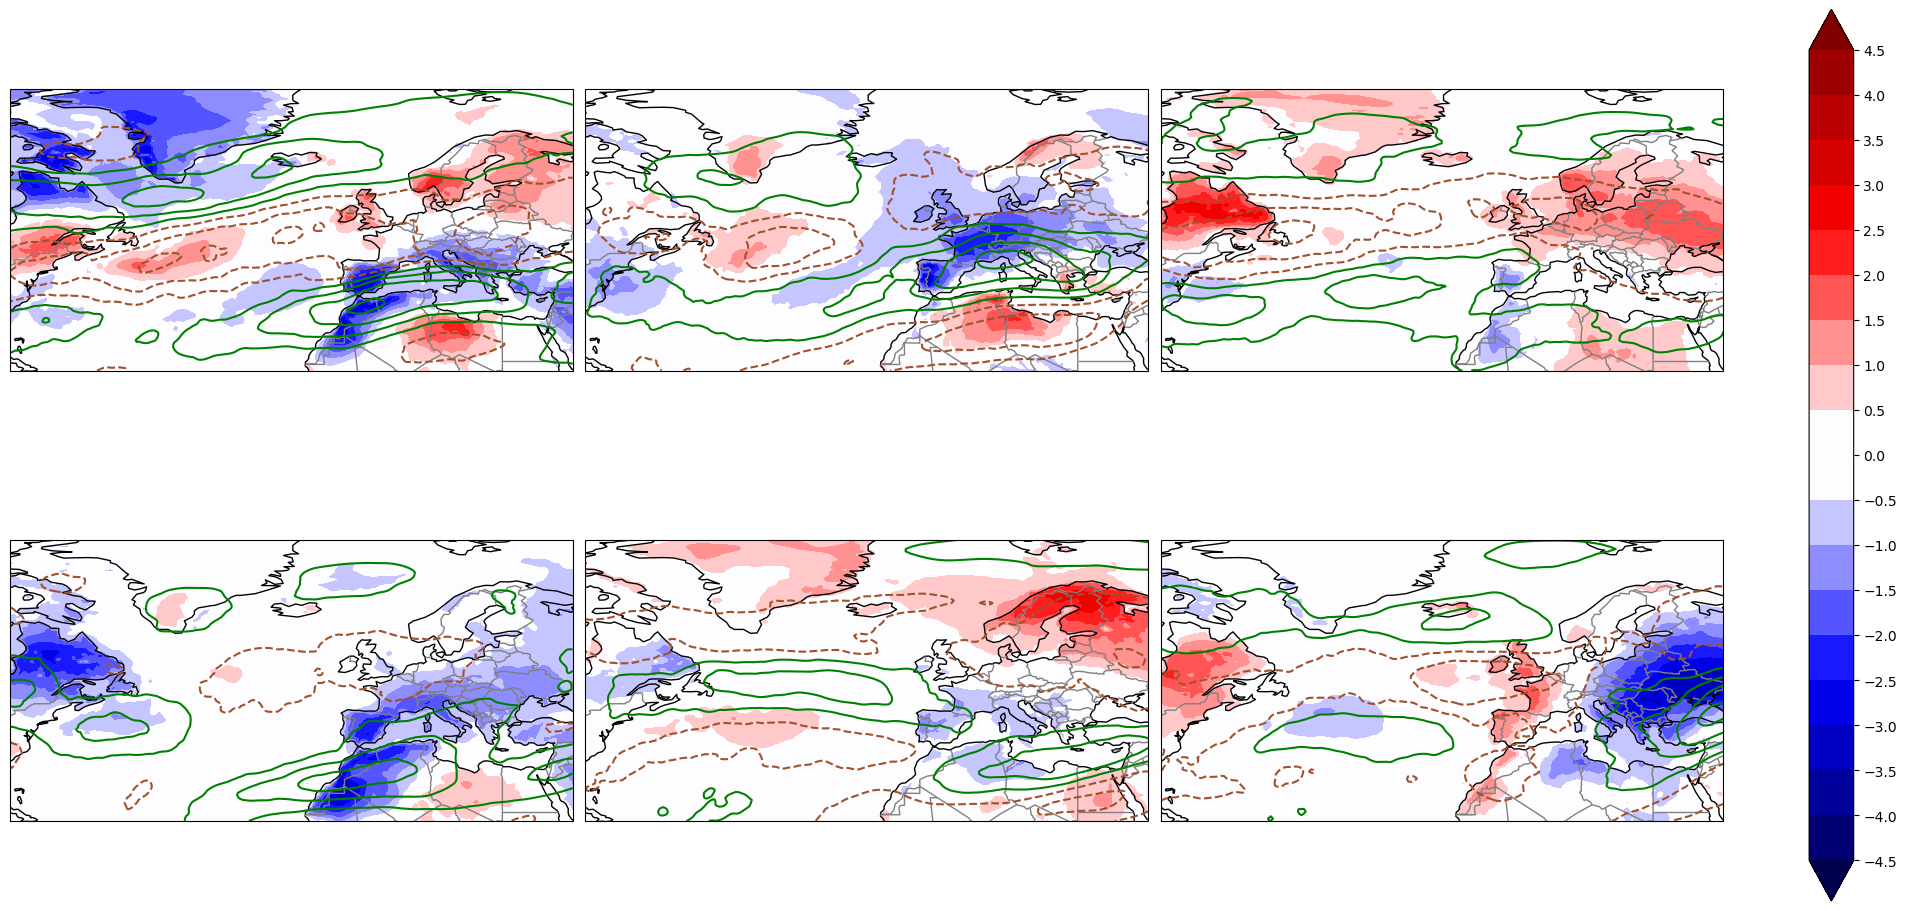

In [92]:
to_plot = [da_T.isel(time=mask_low_val[:, i]).mean(dim='time') for i in range(6)]
fig, axes, cbar = clusterplot(2, 3, to_plot, 10, 4.5, clabels=None, contours=False)
to_plot = [da.isel(time=mask_low_val[:, i]).mean(dim='time') for i in range(6)]
levels = 8
levels2 = int(levels / 2)
colors = levels2 * ['sienna'] + (levels2 + 1) * ['green']
linestyles = levels2 * ['dashed'] + (levels2 + 1) * ['solid']
for ax, toplt in zip(axes, to_plot):
    toplt.plot.contour(ax=ax, add_colorbar=False, add_labels=False, levels=levels, vmin=-10, vmax=10, colors=colors, linestyles=linestyles)